## Preparation

In [1]:
from geoproc import Image

In [2]:
import folium

def _leaflet_bounds(map_bounds):
    sw_coord = (map_bounds[1], map_bounds[0])
    ne_coord = (map_bounds[3], map_bounds[2])
    return [sw_coord, ne_coord]

def _geo_add_layer(self, image, name, vis_params={}):
    map_dict = image.get_map(vis_params)
    bounds = _leaflet_bounds(image.map_bounds)
    folium.raster_layers.TileLayer(
      tiles=map_dict['tiles_url'],
      attr='Map data from geoproc :-)',
      name=name,
      overlay=True,
      control=True,
      min_native_zoom=image.info["min_zoom"],
      bounds=bounds,
    ).add_to(self)
    folium.LayerControl(collapsed=False).add_to(self)
    
def _geo_fit_to_image(self, image, **kwargs):
    bounds = _leaflet_bounds(image.map_bounds)
    self.fit_bounds(bounds, **kwargs)

folium.Map.add_layer = _geo_add_layer
folium.Map.fit_to_image = _geo_fit_to_image

## Tiles

In [3]:
img = Image("examples/small_tci.tif")

In [4]:
img.map_bounds

[-1.98019740485087, 49.54811254183769, -1.4669059289362074, 49.74632896368088]

In [5]:
img.info

{'crs': 'EPSG:32630',
 'bounds': [573760.0, 5489510.0, 610460.0, 5510930.0],
 'map_bounds': [-1.98019740485087,
  49.54811254183769,
  -1.4669059289362074,
  49.74632896368088],
 'band_names': ['B1', 'B2', 'B3'],
 'dtype': 'uint8',
 'min_zoom': 9,
 'max_zoom': 13}

In [6]:
# Define a map
m = folium.Map()

# Add the image layer to the map and display it.
m.add_layer(img, 'tci')

# Fit bounds to image
m.fit_to_image(img)

display(m)

In [7]:
img.export?

Signature:
img.export(
    path: 'str',
    *,
    bounds: 'Optional[BBox]' = None,
    scale: 'float' = 1000,
    in_crs: 'str' = 'epsg:4326',
    crs: 'str' = 'epsg:4326',
)
Docstring: <no docstring>
File:      ~/Projects/geoproc/geoproc/image.py
Type:      method


In [8]:
for i in [50, 100, 200]:
    img.export(f"tmp/tci_{i}.tif", scale=i, crs="epsg:32630")
    img.export(f"tmp/tci_{i}_epsg4326.tif", scale=i)
    print("scale", i)    

scale 50
scale 100
scale 200


In [9]:
img.export("tmp/bad_3857.tif", scale=10, crs="epsg:3857")

{'result': 'ok'}

In [10]:
img.export("tmp/bad_utm.tif", scale=10, crs="epsg:32630")

{'result': 'ok'}

In [11]:
img.export("tmp/bad_4326.tif", scale=10)

{'result': 'ok'}

## Merging

In [12]:
from glob import glob

In [13]:
images = [Image.load(f"examples/{p}") for p in sorted(glob("tiles_cog/*.tif"))]

In [14]:
new_img = images[0]
for img in images[1:]:
    new_img = new_img + img

In [15]:
new_img.graph

{'name': '__add__',
 'args': [{'name': '__add__',
   'args': [{'name': '__add__',
     'args': [{'name': '__add__',
       'args': [{'name': '__add__',
         'args': [{'name': '__add__',
           'args': [{'name': '__add__',
             'args': [{'name': '__add__',
               'args': [{'name': '__add__',
                 'args': [{'name': '__add__',
                   'args': [{'name': '__add__',
                     'args': [{'name': '__add__',
                       'args': [{'name': 'load',
                         'args': ['examples/tiles_cog/merged.tif']},
                        {'name': 'load',
                         'args': ['examples/tiles_cog/small_tci_1_1.tif']}]},
                      {'name': 'load',
                       'args': ['examples/tiles_cog/small_tci_1_2.tif']}]},
                    {'name': 'load',
                     'args': ['examples/tiles_cog/small_tci_1_3.tif']}]},
                  {'name': 'load',
                   'args': ['examples/tile

In [16]:
from rasterio.warp import transform_bounds

In [17]:
new_img.info

{'crs': 'EPSG:32630',
 'bounds': [573760.0, 5489510.0, 610460.0, 5510930.0],
 'map_bounds': [-1.98019740485087,
  49.54811254183769,
  -1.4669059289362074,
  49.74632896368088],
 'band_names': ['B1', 'B2', 'B3'],
 'dtype': "<class 'numpy.float64'>",
 'min_zoom': 9,
 'max_zoom': 13}

In [18]:
transform_bounds("epsg:4326", new_img.crs, *new_img.map_bounds)

(573469.4688662735, 5488889.345627183, 610896.6842112895, 5511554.869245463)

In [19]:
new_img.bounds

[573760.0, 5489510.0, 610460.0, 5510930.0]

In [20]:
map_bounds = transform_bounds(new_img.crs, "epsg:4326", *new_img.bounds)
transform_bounds("epsg:4326", new_img.crs, *map_bounds)

(573469.4688662735, 5488889.345627183, 610896.6842112895, 5511554.869245463)

<Axes: >

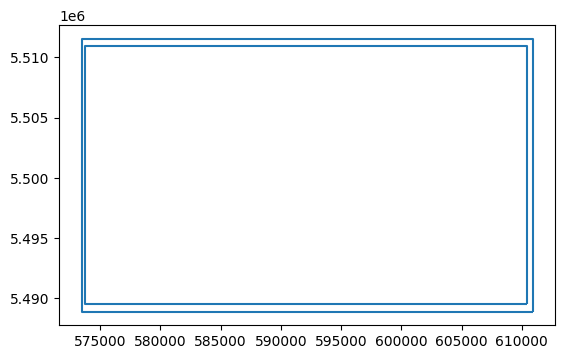

In [21]:
from pyproj import CRS, Transformer
from shapely.ops import transform, unary_union
from shapely.geometry import box, mapping
import geopandas as gpd

bbox = box(*new_img.bounds)
map_bbox = box(*transform_bounds("epsg:4326", new_img.crs, *new_img.map_bounds))

bboxes_df = gpd.GeoDataFrame(geometry=[bbox, map_bbox])
bboxes_df.boundary.plot()

In [22]:
mapping(box(*new_img.map_bounds))

{'type': 'Polygon',
 'coordinates': (((-1.4669059289362074, 49.54811254183769),
   (-1.4669059289362074, 49.74632896368088),
   (-1.98019740485087, 49.74632896368088),
   (-1.98019740485087, 49.54811254183769),
   (-1.4669059289362074, 49.54811254183769)),)}

In [23]:
# Define a map centered on southern Maine.
m = folium.Map(location=[49.64746484638939, -1.724064228348934], zoom_start=8)

# Add the image layer to the map and display it.
m.add_layer(new_img, 'merged')
m.fit_to_image(new_img)

# latlon_bounds = [new_img.map_bounds[1], new_img.map_bounds[0], new_img.map_bounds[3], new_img.map_bounds[2]]
# geo_bounds = folium.GeoJson(data=mapping(box(*latlon_bounds)), style_function=lambda x: {'fillColor': 'orange'})
# geo_bounds.add_to(m)

display(m)

In [24]:
img = Image("examples/tiles_cog/small_tci_1_1.tif")

In [25]:
img.export("tmp/small_aoi_1.tif", scale=10, bounds=(-1.9501848031186266, 49.6786269549578634, -1.9166549106804431,49.6961130287977397))

{'result': 'ok'}

In [26]:
img.export("tmp/small_aoi_2.tif", scale=50, crs="epsg:32630", bounds=(-1.9293047014294760,49.6893917308600663,-1.8960423816304390,49.7036349607845409))

{'result': 'ok'}

In [27]:
add_img = Image("tmp/small_aoi_1.tif") + Image("tmp/small_aoi_2.tif")
add_img.export("tmp/added.tif", scale=10)

{'result': 'ok'}

In [28]:
# Define a map centered on southern Maine.
map_tci = folium.Map(location=[49.64746484638939, -1.724064228348934], zoom_start=11)

# Add the image layer to the map and display it.
map_tci.add_layer(add_img, 'added')
map_tci.fit_to_image(add_img)
folium.LayerControl().add_to(map_tci)

display(map_tci)

## Visualization

In [29]:
img = Image("examples/small_tci.tif")

In [30]:
# Define a map centered on southern Maine.
map_tci = folium.Map(location=[49.64746484638939, -1.724064228348934], zoom_start=11)

# Add the image layer to the map and display it.
map_tci.add_layer(img, 'merged', {"bands": ["B3"]})
folium.LayerControl().add_to(map_tci)

display(map_tci)

In [31]:
# Define a map centered on southern Maine.
map_tci = folium.Map(location=[49.64746484638939, -1.724064228348934], zoom_start=11)

# Add the image layer to the map and display it.
map_tci.add_layer(img, 'merged', {"bands": ["b1", "b2", "b3"], "min": 0, "max": 100})
folium.LayerControl().add_to(map_tci)

display(map_tci)

In [32]:
# Define a map centered on southern Maine.
map_tci = folium.Map(location=[49.64746484638939, -1.724064228348934], zoom_start=11)

# Add the image layer to the map and display it.
map_tci.add_layer(img, 'merged', {"bands": ["b1", "b2", "b3"], "min": 0, "max": 255, "opacity": 0.5})
folium.LayerControl().add_to(map_tci)

display(map_tci)